### Paso 1: Importación de librerías

In [1]:
# Librerias utilizadas
# pip install yfinance
# o si es en Conda, conda install -c ranaroussi yfinance
import yfinance as yf
import pandas as pd
import os

from datetime import datetime
import pytz

### Paso 2: Stocks seleccionados

In [2]:
# Descargamos los datos de Yahoo Finance
# Si no existe el archivo, lo descargamos
# Si existe, lo leemos

# SP500
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

# TSLA
if os.path.exists("tsla.csv"):
    tsla = pd.read_csv("tsla.csv", index_col=0)
else:
    tsla = yf.Ticker("TSLA")
    tsla = tsla.history(period="max")
    tsla.to_csv("tsla.csv")

# Stock seleccionado por analizar:
stock = tsla

### Paso 3: Limpieza de Datos

In [3]:
# Convertimos el indice a formato fecha usando pandas
# print(sp500.index)
stock.index = pd.to_datetime(stock.index)
stock = stock.dropna(subset=stock.columns[stock.columns != "Tomorrow"])

del stock["Dividends"]
del stock["Stock Splits"]
stock["Tomorrow"] = stock["Close"].shift(-1)
stock["Target"] = (stock["Tomorrow"] > stock["Close"]).astype(int)

min_date = datetime(year=2020, month=1, day=1)
min_date = pytz.utc.localize(min_date)
stock = stock[stock.index > min_date]

<Axes: xlabel='Date'>

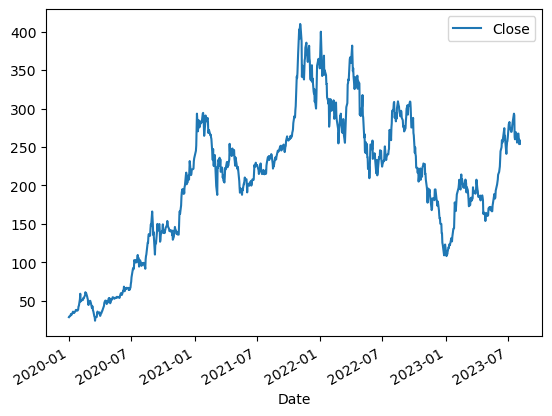

In [4]:
stock.plot.line(y="Close", use_index=True)

### Paso 4: División de la Muestra

In [5]:
# Dividimos el dataset en train y test
# Hacemos el modelo del 
train = stock.iloc[:-100]
test = stock.iloc[-100:]

Si una inteligencia artificial fuera una funcion de varios inputs,
f(x1, x2, x3, ..., xn) = y,
x1 al xn serían las variables de entrada, `predictors = ["Close", "Volume", "Open", "High", "Low"]`

y sería la variable de salida sería Target, que representa si el precio de la acción subió o bajó.

### Paso 5: Selección de Predictores

In [7]:
horizons = [2,4,8,16,32,64,128,256]
predictors = []

for horizon in horizons:
    rolling_averages = stock.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    stock[ratio_column] = stock["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    stock[trend_column] = stock.shift(1).rolling(horizon).sum()["Target"]
    
    predictors+= [ratio_column, trend_column]

# Predictores que no vamos a usar
# predictors = ["Close", "Volume", "Open", "High", "Low"] # Variables que vamos a usar para predecir

### Paso 6: Diseño y Creación de Modelo

In [8]:
# Modelo
from sklearn.ensemble import RandomForestClassifier

#model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
model.fit(train[predictors], train["Target"])

KeyError: "None of [Index(['Close_Ratio_2', 'Trend_2', 'Close_Ratio_4', 'Trend_4', 'Close_Ratio_8',\n       'Trend_8', 'Close_Ratio_16', 'Trend_16', 'Close_Ratio_32', 'Trend_32',\n       'Close_Ratio_64', 'Trend_64', 'Close_Ratio_128', 'Trend_128',\n       'Close_Ratio_256', 'Trend_256'],\n      dtype='object')] are in the [columns]"

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

# this 

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

Métricas de Evaluación de Modelo

In [ ]:
# Métricas de evaluación
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

In [ ]:
predictions = backtest(stock, model, predictors)

In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)